# House Prices: Advanced Regression Techniques

Competition web page: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### Description

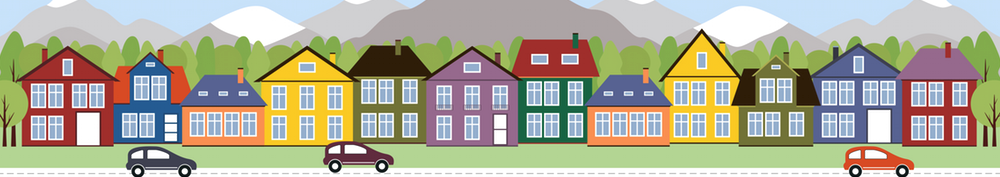

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Fire up imports

Trick to install a package in docker container

In [3]:
import pip    
def install(package):
   pip.main(['install', package])

In [4]:
import csv
import operator
import os
import pandas
import re
import sklearn
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
# Comment out if necessary
warnings.simplefilter("ignore", category=RuntimeWarning)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Helper functions

In [5]:
#### Correlation heat map
def plot_correlation_map( df ):
    corr = train_data.corr()
    _ , ax = plt.subplots( figsize =( 20 , 18 ) )
    #cmap = sns.diverging_palette( 250 , 255, as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap="YlGnBu",
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = False    
    )

# Bar plot
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None )
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[ var ].max()))
    facet.add_legend()

### Read some house data

In [6]:
data_dir = 'data'
#separator = '|'
#column_names = ['link', 'date', 'title', 'category', 'body']

In [7]:
train_file = os.path.join(data_dir, 'train.csv')
train_data = pandas.read_csv(train_file)

In [8]:
# check train data size
len(train_data)

1460

In [9]:
# Let`s look at the data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']

Let`s check the attributes types

In [12]:
print("Quantitative: ", quantitative,)

Quantitative:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [13]:
print("Qualitative: ", qualitative,)

Qualitative:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Look at the missing attributes

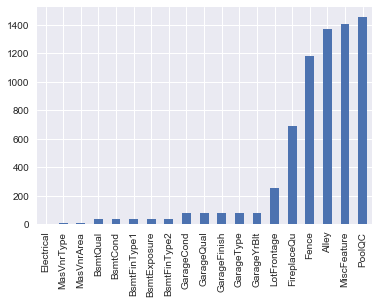

In [14]:
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

## 1. COMPREHENSIVE DATA EXPLORATION

Taken from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
What we are doing in this kernel is something like:

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.

2. **Univariable study**. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.

3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.

4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers and categorical variables.

5. **Test assumptions**. We'll check if our data meets the assumptions required by most multivariate techniques.

#### 1.1 Understand the problem

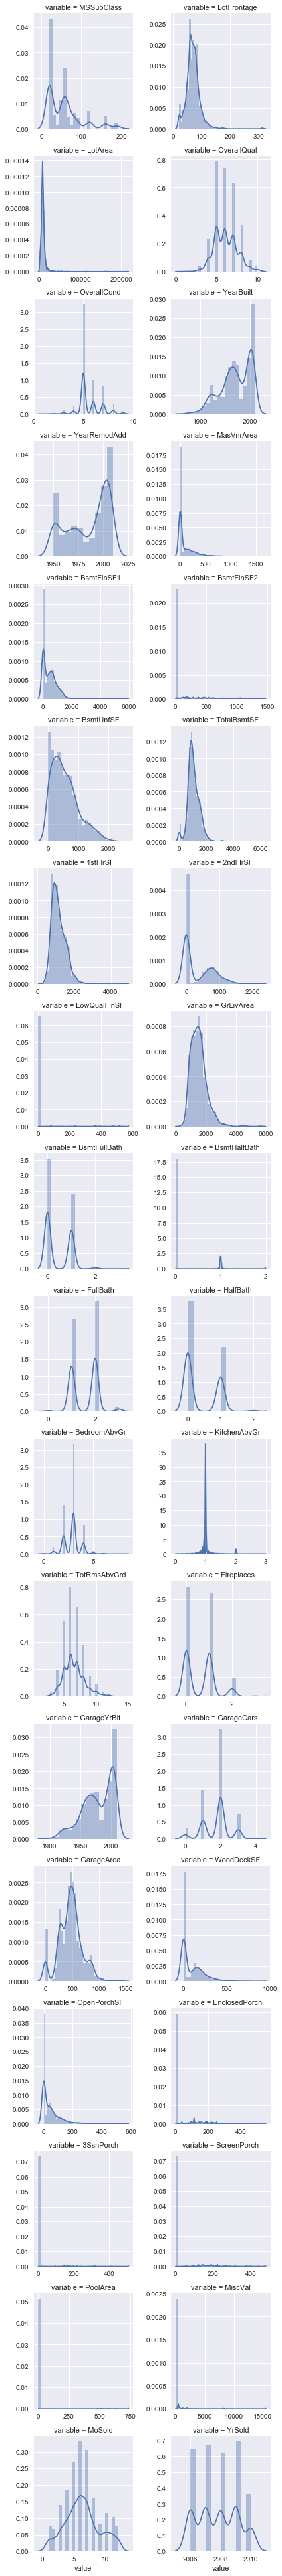

In [15]:
f = pandas.melt(train_data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Let's plot a correlation heat-map allowing us to see how the different attributes are related to each other.

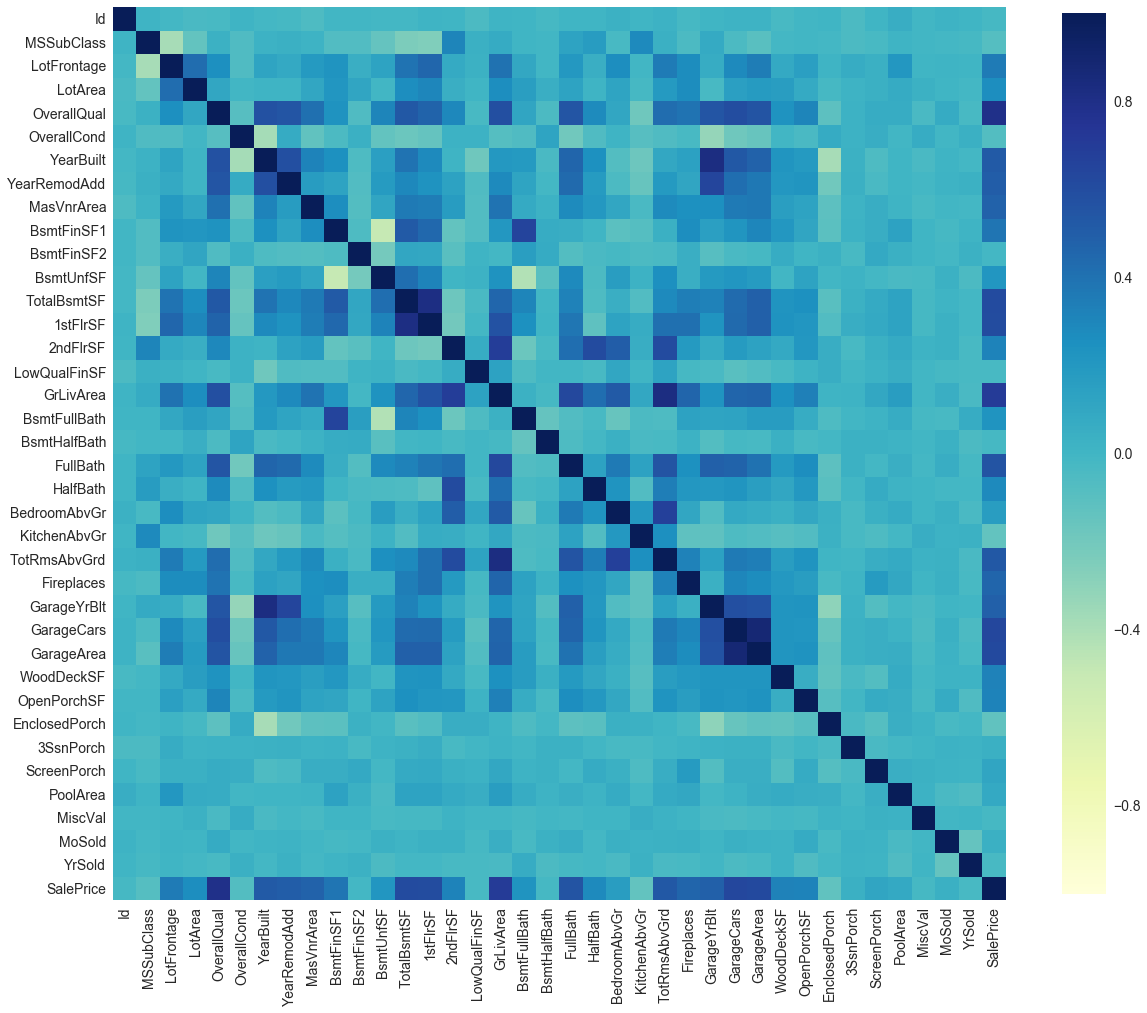

In [16]:
sns.set(font_scale=1.4)
plot_correlation_map(train_data)

As we can see from the above heatmap, OverallQual, GrLivArea, Fullbath, GarageCars, GarageArea 
have a good correlation with SalePrice.

RECAP
GrLivArea: Above grade (ground) living area square feet

In [17]:
train_data['OverallQual'].head()

0    7
1    6
2    7
3    7
4    8
Name: OverallQual, dtype: int64

In [18]:
train_data['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

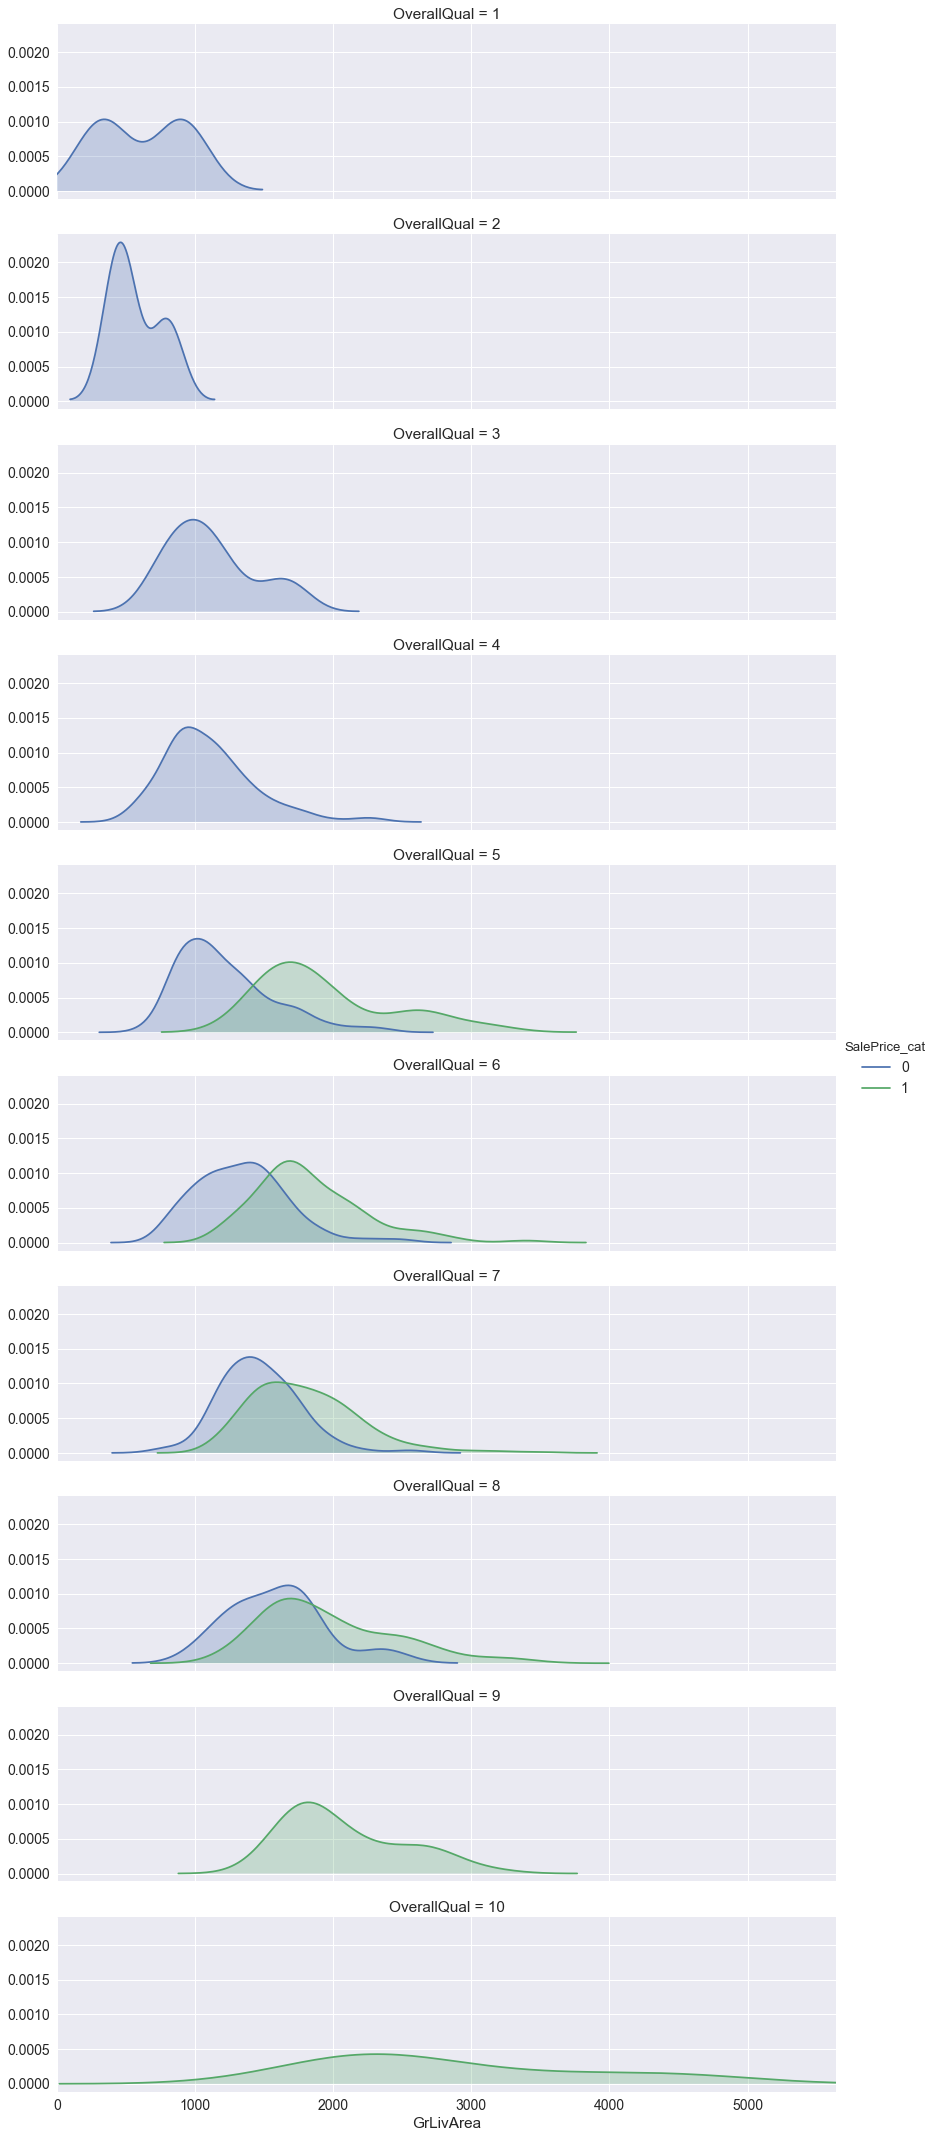

In [19]:
categorized_sale_price = train_data
# SalePrice_cat: SalePrice categorized
def cat_sale_price(row):
    # 180921.195890 is the mean of all the 'SalePrice' values
    if row['SalePrice']>180921.195890:
        return 1
    else:
        return 0
    
categorized_sale_price['SalePrice_cat'] = categorized_sale_price.apply(cat_sale_price, axis=1)
categorized_sale_price = categorized_sale_price.dropna(subset=['GrLivArea', 'SalePrice_cat', 'OverallQual']) 

# looking at the relationship between above ground living area and sale price.
# What's happening here?
# plot_distribution( dataframe , var = X_axis , target = CURVED_LINE , row = Each_Facet )
# Each_Facet: Each of the below graphs correspond to a category value of 'OverallQual'.

plot_distribution(categorized_sale_price, var='GrLivArea', target='SalePrice_cat', row='OverallQual')

The sale price tends to be on the lower range when the overall material and finish quality is in the range of 1 to 5. The sale price tends to be on the higher side when 'OverallQual' is in the range of 9 to 10.

In [20]:
train_data['GarageArea'].describe()

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

Let's have a look at the relationship between 'GarageArea' and sale price.

GarageArea: Size of garage in square feet

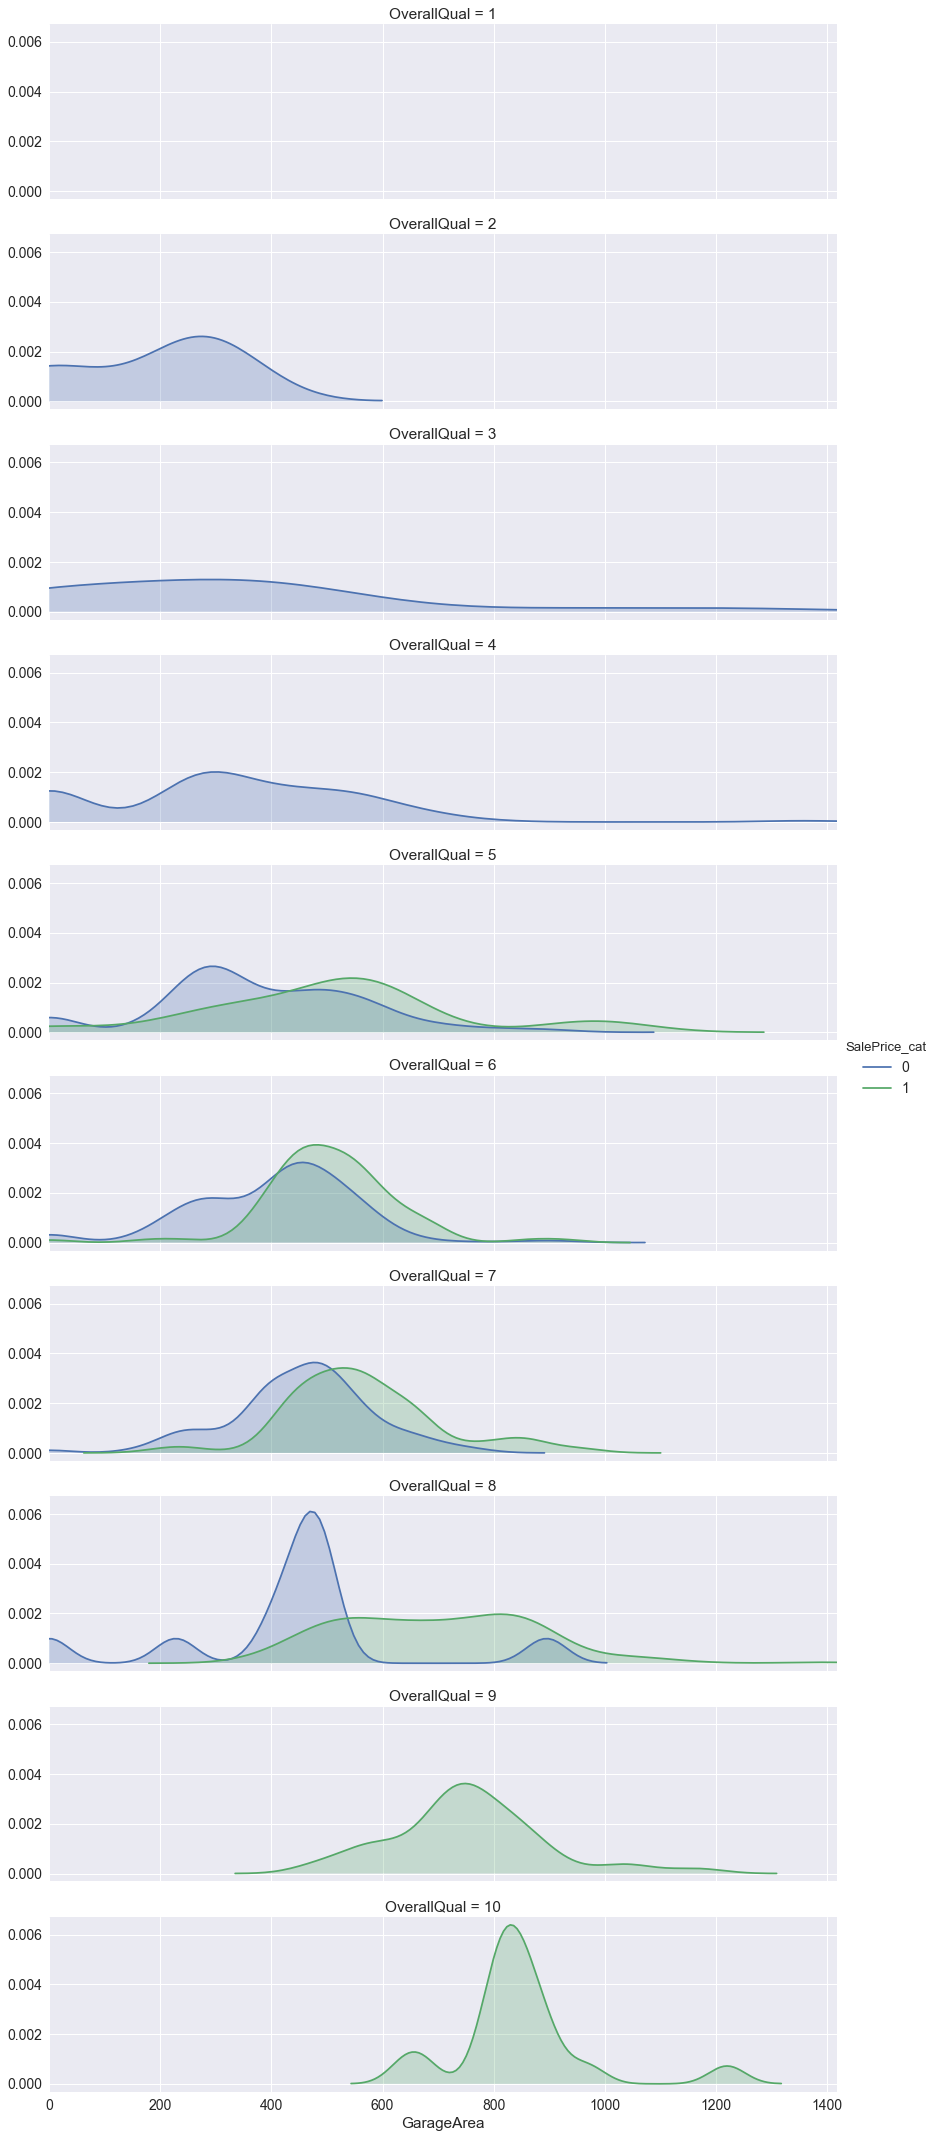

In [21]:
plot_distribution(categorized_sale_price, var='GarageArea', target='SalePrice_cat', row='OverallQual')

The probability of a higher sale price tends to peak when the 'OverallQual' is 10 and the garage area
is in the range 800-900 square feet.
The garage area seems to be a zero when the 'OverallQual' is a lowly 1.

In [22]:
train_data['FullBath'].describe()

count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

FullBath: Full bathrooms above grade

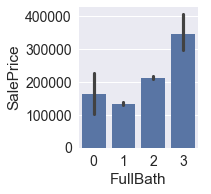

In [23]:
plot_categories(train_data, cat='FullBath', target='SalePrice')

We do see a rise in the sale price as the number of full bathrooms increases from 1 to 3, although the sale price might be higher for 0 full bathrooms than for houses with 1 bathroom.

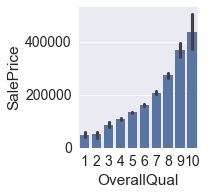

In [24]:
plot_categories(train_data, cat='OverallQual', target='SalePrice')

We see a strong correlation between 'OverallQual' and 'SalePrice'

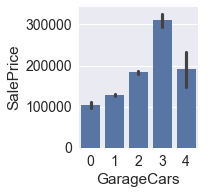

In [25]:
plot_categories(train_data, cat='GarageCars', target='SalePrice')

GarageCars: Size of garage in car capacity
The sale price actually dips when the 'GarageCars' is 4, until then there is a good rise from 0.

Let's now focus on the categorical variables, out of the few variables we have had a look at.

OverallQual, FullBath, GarageCars

In [26]:
# Here we create 10 different columns for 10 different category values.
# 0 - The property(or row) is not associated with the respective category variable.
# 1 - The property(or row) is associated with the respective category variable.
overallQual = pandas.get_dummies(train_data.OverallQual, prefix='OverallQual')
overallQual.head()

,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0


In [27]:
fullBath = pandas.get_dummies(train_data.FullBath, prefix='FullBath')
fullBath.head()

,FullBath_0,FullBath_1,FullBath_2,FullBath_3
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0


In [28]:
garageCars = pandas.get_dummies(train_data.GarageCars, prefix='GarageCars')
garageCars.head()

,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


Let's fill out any missing values in which are part of continuous variables(GrLivArea, GarageArea).

In [29]:
non_empty = pandas.DataFrame()

non_empty['GrLivArea'] = train_data.GrLivArea.fillna(train_data.GrLivArea.mean())
non_empty['GarageArea'] = train_data.GarageArea.fillna(train_data.GarageArea.mean())

non_empty.head()

,GrLivArea,GarageArea
0,1710,548
1,1262,460
2,1786,608
3,1717,642
4,2198,836
